In [1]:
!pip install apafib --upgrade  --quiet

  Preparing metadata (setup.py) ... done


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from time import time
from datetime import timedelta
init_time = time()

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,  KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import set_config

from yellowbrick.regressor import AlphaSelection

from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm
from scipy import stats

import warnings
import logging

logging.getLogger('matplotlib').setLevel(logging.ERROR)
set_config(display='text')
warnings.filterwarnings('ignore')

sns.set()
pd.set_option('display.precision', 3)

# **Problema grupal: El precio de las cosas y más**

Asumimos que los precios de las cosas están ligados entre ellos de manera más o menos compleja, eso mueve todo lo que está relacionado con la economía, como por ejemplo la bolsa. A
veces hay cosas que pueden estar relacionadas también de manera más o menos coherente y
permite descubrir factores desconocidos pueden sorprendernos (o ser simplemente espurios).

El ayuntamiento de Barcelona recolecta diversos datos sobre la ciudad en su portal de datos
abiertos. Vamos a trabajar con un extracto de esos datos para los años 2022-2023, eligiendo
un subconjunto de variables que tienen que ver con la economía, como el precio de productos
de la cesta de la compra o el número de matriculaciones de vehículos y, por lo tanto, tendrán alguna relación con el índice IBEX. De manera exploratoria añadiremos una serie de variables
que no parecen tener relación y que si es el caso no tendrán un peso en el modelo, como son la
temperatura medida en diferentes puntos de la ciudad y el nivel de ruido a diferentes horas del
día.

Podéis obtener estos datos mediante la función load_BCN_precios de la librería apafib. Resolved los siguientes apartados ilustrando los resultados de la manera que os parezca más adecuada.

## Lectura de los datos

Antes de manipular los datos debemos leerlos:

In [4]:
# Usamos la libreria apafib para leer los datos
from apafib import load_BCN_precios
BCN_precios_data = load_BCN_precios()

# Eliminamos los espacios y símbolos para evitar problemas con statsmodel GLM
BCN_precios_data.columns = [c.lower().strip().replace(' ','_').replace('/','_').replace('-','_')
                                for c in BCN_precios_data.columns]

# Reordenamos las columnas de manera que la variable respuesta sea la primera
cols = list(BCN_precios_data.columns)
cols.remove('ibex_ibex')
cols.insert(0, 'ibex_ibex')
BCN_precios_data = BCN_precios_data.reindex(columns=cols)

# Cambiamos el tipo de las variables categoricas a category de pandas. +
# Identificamos dichas variables mirando las que son de tipo object (== 'O'),
# las demas seran float, int, etc
categorical_columns = list(BCN_precios_data.dtypes[BCN_precios_data.dtypes == 'O'].index.values)
for column in categorical_columns:
    BCN_precios_data[column] = BCN_precios_data[column].astype('category')

print(f"El número de filas en el dataset es: {BCN_precios_data.shape[0]}")

# Miramos las primeras filas de los datos
BCN_precios_data.head()

El número de filas en el dataset es: 630


,ibex_ibex,frutas_ceba,frutas_patata,frutas_plàtan,frutas_poma,frutas_taronja,carnes_llenguado,carnes_llobarro,carnes_lluç,carnes_orada,carnes_pollastre,carnes_porcí,temperatura_barcelona___el_raval,temperatura_barcelona___observatori_fabra,temperatura_barcelona___zona_universitària,matriculaciones_turismes,matriculaciones_vehicles,contaminacionacustica_19h,contaminacionacustica_4h
Dia,,,,,,,,,,,,,,,,,,,
2021-09-15,8635.400,0.32,0.35,1.0,0.900,0.9,13.800,5.0,4.000,4.5,0.890,1.200,26.79,24.38,26.07,33.0,119.000,66.41,50.94
2021-09-16,8733.700,0.30,0.43,1.0,0.900,0.9,13.600,5.0,3.800,4.5,0.899,1.196,24.46,21.46,23.99,53.0,124.000,66.44,50.68
2021-09-17,8760.900,0.30,0.43,1.0,0.900,0.9,13.600,5.5,4.000,4.5,0.907,1.191,24.95,22.20,23.92,47.0,109.000,66.65,51.08
2021-09-18,8725.733,0.30,0.43,1.0,0.867,0.9,13.500,5.5,4.000,4.5,0.916,1.187,23.48,20.41,22.18,47.0,116.333,65.80,53.54
2021-09-19,8690.567,0.30,0.43,1.0,0.833,0.9,13.533,5.5,4.267,4.5,0.924,1.183,22.20,19.01,21.28,47.0,123.667,65.19,53.83


## Análisis exploratorio de los datos

Siempre es una buena idea hacer una pequeña exploración de los datos. Los datos reales necesitan procesamiento previo y es importante comprender su conjunto de datos para poder tomar buenas decisiones de diseño.

Vamos a hacer una visualización rápida de los datos. En esta visualización usamos histogramas para mostrar la distribución de las variables numéricas y diagramas de barras para las categóricas.

Con este tipo de visualizaciones fáciles, podemos ver mucha información relevante sobre nuestros datos, como si tenemos nuestros valores o si alguna variable se ha codificado incorrectamente, o si "parece" lo suficientemente gaussiana.



In [5]:
print(f"En nuestros datos tenemos {BCN_precios_data.shape[1]} columnas (1 es la variable objetivo)\n")
BCN_precios_data.describe(include='all').T
BCN_precios_data.info()

En nuestros datos tenemos 19 columnas (1 es la variable objetivo)



,count,mean,std,min,25%,50%,75%,max
ibex_ibex,630.0,8564.088,494.207,7261.10,8203.033,8578.150,8942.158,9511.00
frutas_ceba,630.0,0.575,0.283,0.22,0.270,0.520,0.750,1.25
frutas_patata,630.0,0.577,0.126,0.35,0.480,0.600,0.650,0.85
frutas_plàtan,630.0,1.806,0.598,1.00,1.300,1.800,2.000,3.20
frutas_poma,630.0,0.873,0.194,0.60,0.733,0.800,1.000,1.60
frutas_taronja,630.0,0.965,0.198,0.40,0.800,0.900,1.100,1.60
carnes_llenguado,630.0,17.602,2.638,12.80,15.000,18.000,19.125,29.00
carnes_llobarro,630.0,5.972,0.476,5.00,5.600,5.900,6.400,6.85
carnes_lluç,630.0,4.640,0.781,2.50,4.000,4.600,5.167,7.50
carnes_orada,630.0,4.928,0.411,4.20,4.571,4.942,5.300,5.80


<class 'pandas.core.frame.DataFrame'>
Index: 630 entries, 2021-09-15 to 2023-06-06
Data columns (total 19 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   ibex_ibex                                   630 non-null    float64
 1   frutas_ceba                                 630 non-null    float64
 2   frutas_patata                               630 non-null    float64
 3   frutas_plàtan                               630 non-null    float64
 4   frutas_poma                                 630 non-null    float64
 5   frutas_taronja                              630 non-null    float64
 6   carnes_llenguado                            630 non-null    float64
 7   carnes_llobarro                             630 non-null    float64
 8   carnes_lluç                                 630 non-null    float64
 9   carnes_orada                                630 non-null    float64
 10  car

Dado que tenemos features con nombres largos, procedemos a realizar un renombramiento de las features que nos facilitará tanto el acceso a ellas como la visualización de los gráficos.

In [6]:
nombres_nuevos = {
    'ibex_ibex': 'ibex',
    'frutas_ceba': 'cebolla',
    'frutas_plàtan': 'platano',
    'frutas_patata': 'patata',
    'frutas_poma': 'manzana',
    'frutas_taronja': 'naranja',
    'carnes_llenguado': 'lenguado',
    'carnes_llobarro': 'lubina',
    'carnes_lluç': 'merluza',
    'carnes_orada': 'dorada',
    'carnes_pollastre': 'pollo',
    'carnes_porcí': 'cerdo',
    'temperatura_barcelona___el_raval': 'temp_raval',
    'temperatura_barcelona___observatori_fabra': 'temp_fabra',
    'temperatura_barcelona___zona_universitària': 'temp_uni',
    'matriculaciones_turismes': 'turismos',
    'matriculaciones_vehicles': 'vehiculos',
    'contaminacionacustica_4h': 'contam_4',
    'contaminacionacustica_19h': 'contam_19'
}

BCN_precios_data.rename(columns=nombres_nuevos, inplace=True)
features = BCN_precios_data.loc[:,BCN_precios_data.columns != 'ibex']
BCN_precios_data.head()

,ibex,cebolla,patata,platano,manzana,naranja,lenguado,lubina,merluza,dorada,pollo,cerdo,temp_raval,temp_fabra,temp_uni,turismos,vehiculos,contam_19,contam_4
Dia,,,,,,,,,,,,,,,,,,,
2021-09-15,8635.400,0.32,0.35,1.0,0.900,0.9,13.800,5.0,4.000,4.5,0.890,1.200,26.79,24.38,26.07,33.0,119.000,66.41,50.94
2021-09-16,8733.700,0.30,0.43,1.0,0.900,0.9,13.600,5.0,3.800,4.5,0.899,1.196,24.46,21.46,23.99,53.0,124.000,66.44,50.68
2021-09-17,8760.900,0.30,0.43,1.0,0.900,0.9,13.600,5.5,4.000,4.5,0.907,1.191,24.95,22.20,23.92,47.0,109.000,66.65,51.08
2021-09-18,8725.733,0.30,0.43,1.0,0.867,0.9,13.500,5.5,4.000,4.5,0.916,1.187,23.48,20.41,22.18,47.0,116.333,65.80,53.54
2021-09-19,8690.567,0.30,0.43,1.0,0.833,0.9,13.533,5.5,4.267,4.5,0.924,1.183,22.20,19.01,21.28,47.0,123.667,65.19,53.83


Podemos ver como en nuestros datos no tenemos variables categoricas, por lo tanto vamos realizar un muestreo de los histogramas de cada variable para ver si siguen una distribucion gaussiana o no.

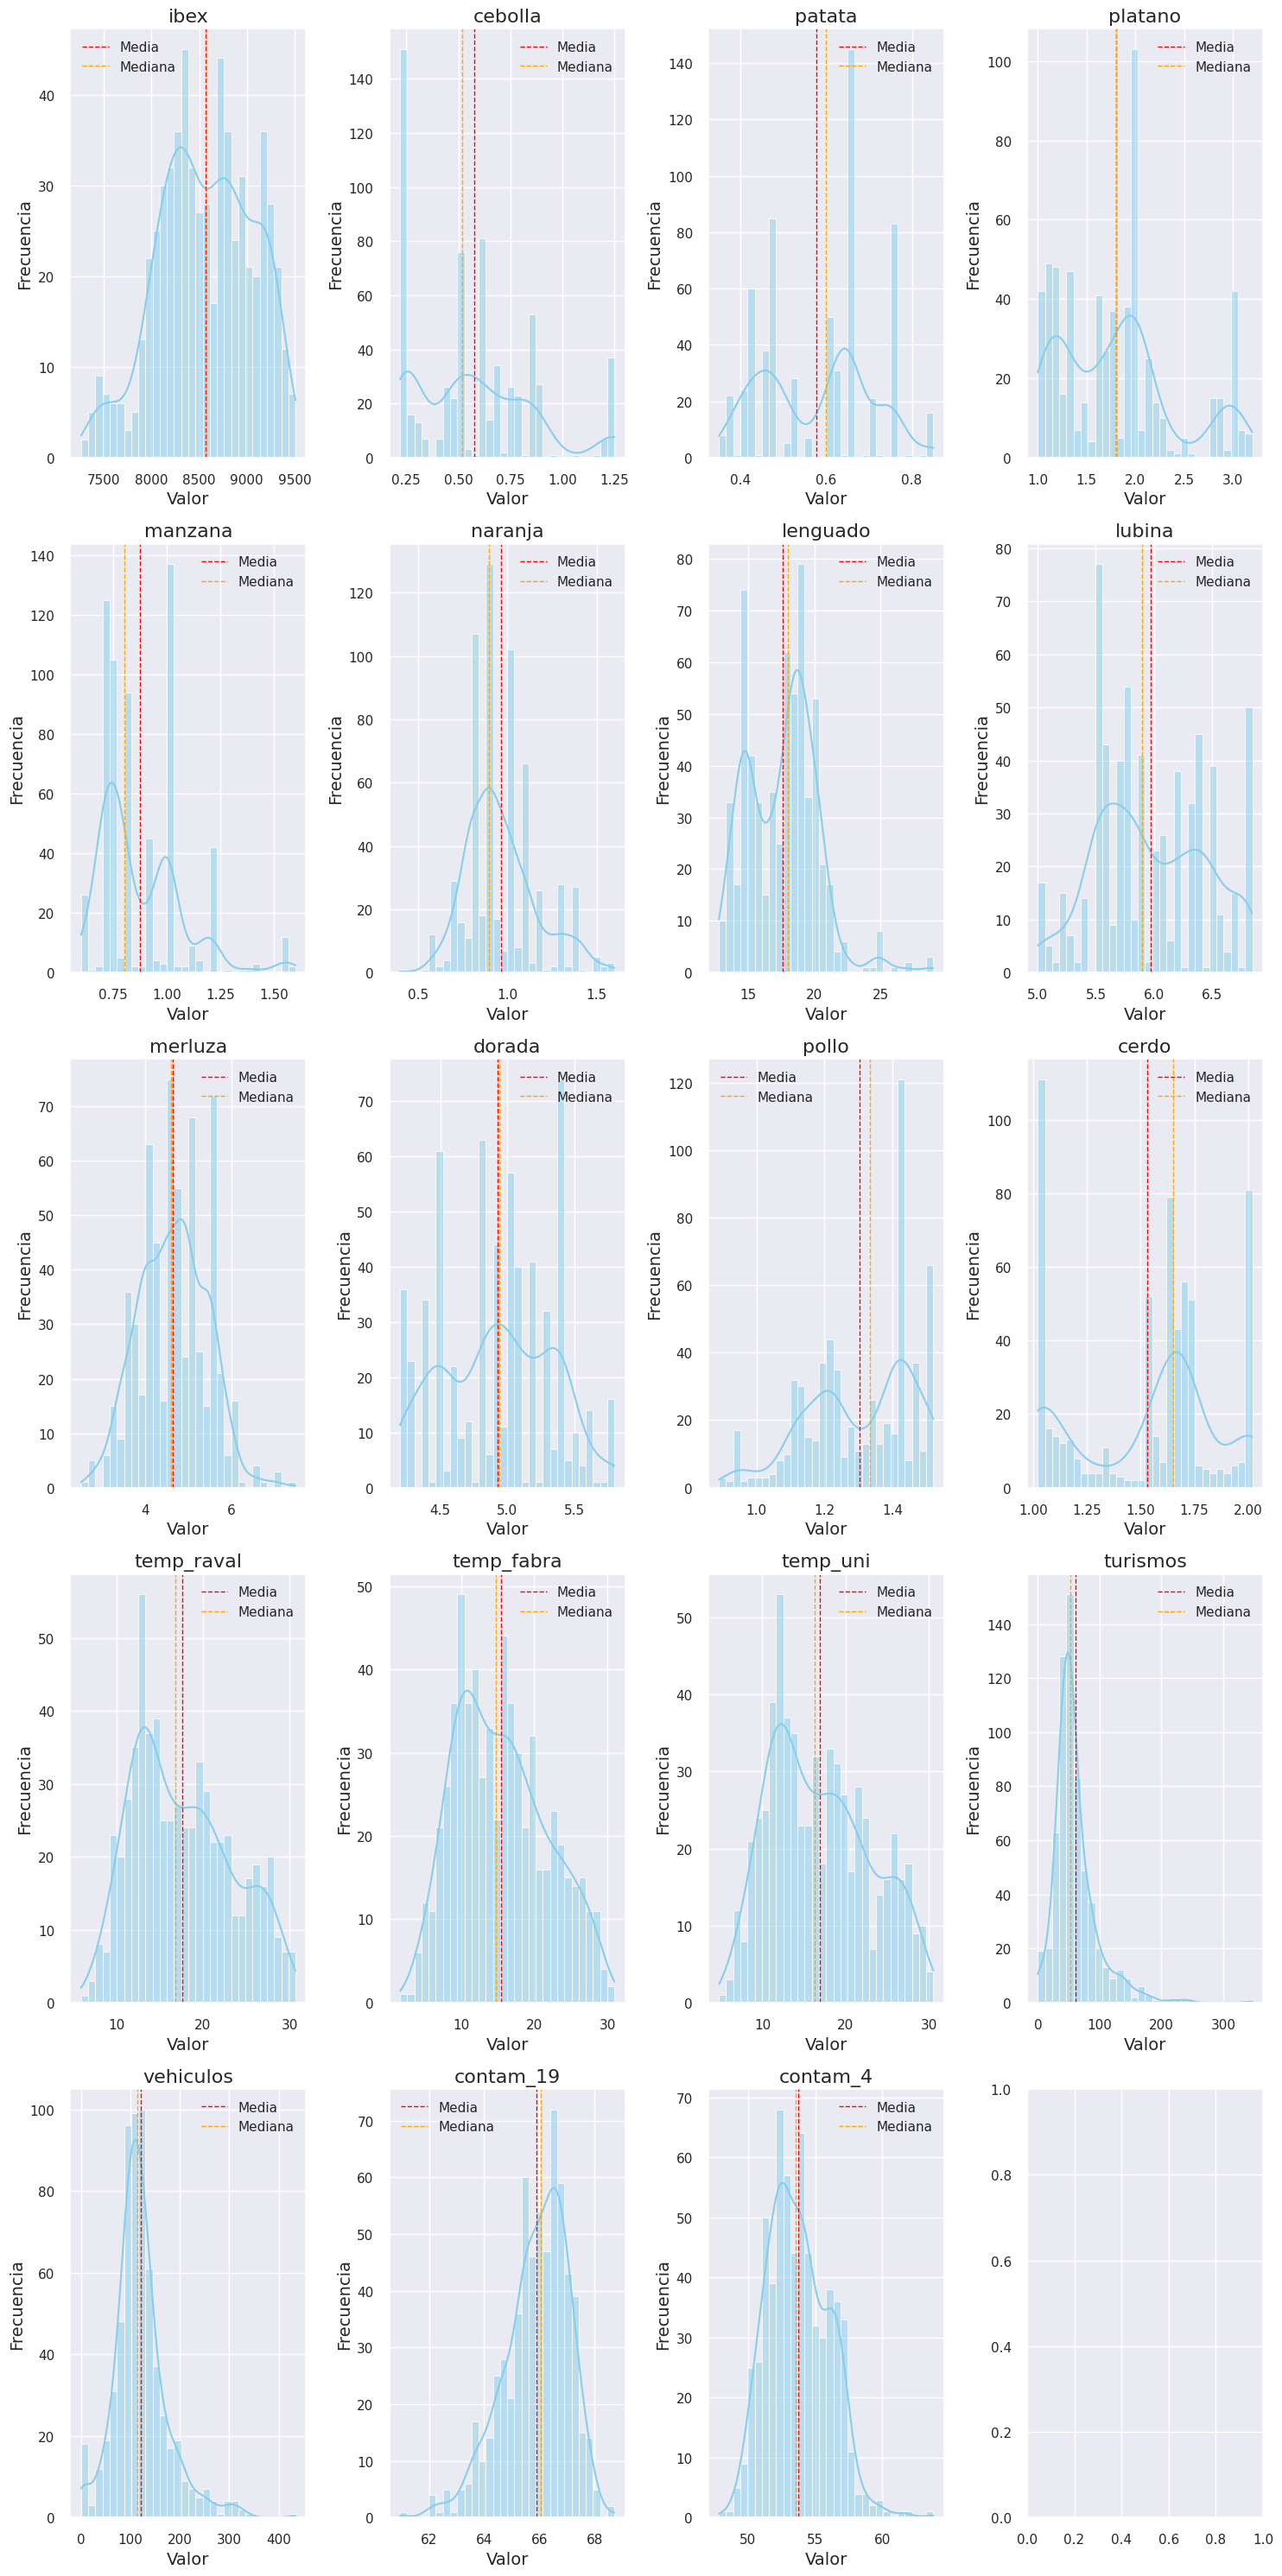

In [7]:
fig, axes = plt.subplots(5, 4, figsize=(15, 30))

for i, c in enumerate(BCN_precios_data.columns):
    ax = axes.flatten()[i]
    sns.histplot(data=BCN_precios_data, x=c, ax=ax, bins=30, kde=True, color='skyblue')
    ax.set_title(c, fontsize=16)
    ax.set_xlabel('Valor', fontsize=14)
    ax.set_ylabel('Frecuencia', fontsize=14)

    mean = BCN_precios_data[c].mean()
    median = BCN_precios_data[c].median()
    ax.axvline(mean, color='red', linestyle='dashed', linewidth=1, label='Media')
    ax.axvline(median, color='orange', linestyle='dashed', linewidth=1, label='Mediana')
    ax.legend()

plt.tight_layout();
plt.show();


Ahora que sabemos cómo se ven nuestros datos, es una buena idea verificar cuántos valores perdidos tenemos en cada variable, si es que tenemos.

In [8]:
BCN_precios_data.shape # devuelve la tupla (#filas, #columnas)
BCN_precios_data.isna().sum().sort_values(ascending=False)

(630, 19)

,0
ibex,0
pollo,0
contam_19,0
vehiculos,0
turismos,0
temp_uni,0
temp_fabra,0
temp_raval,0
cerdo,0
dorada,0


<Axes: >

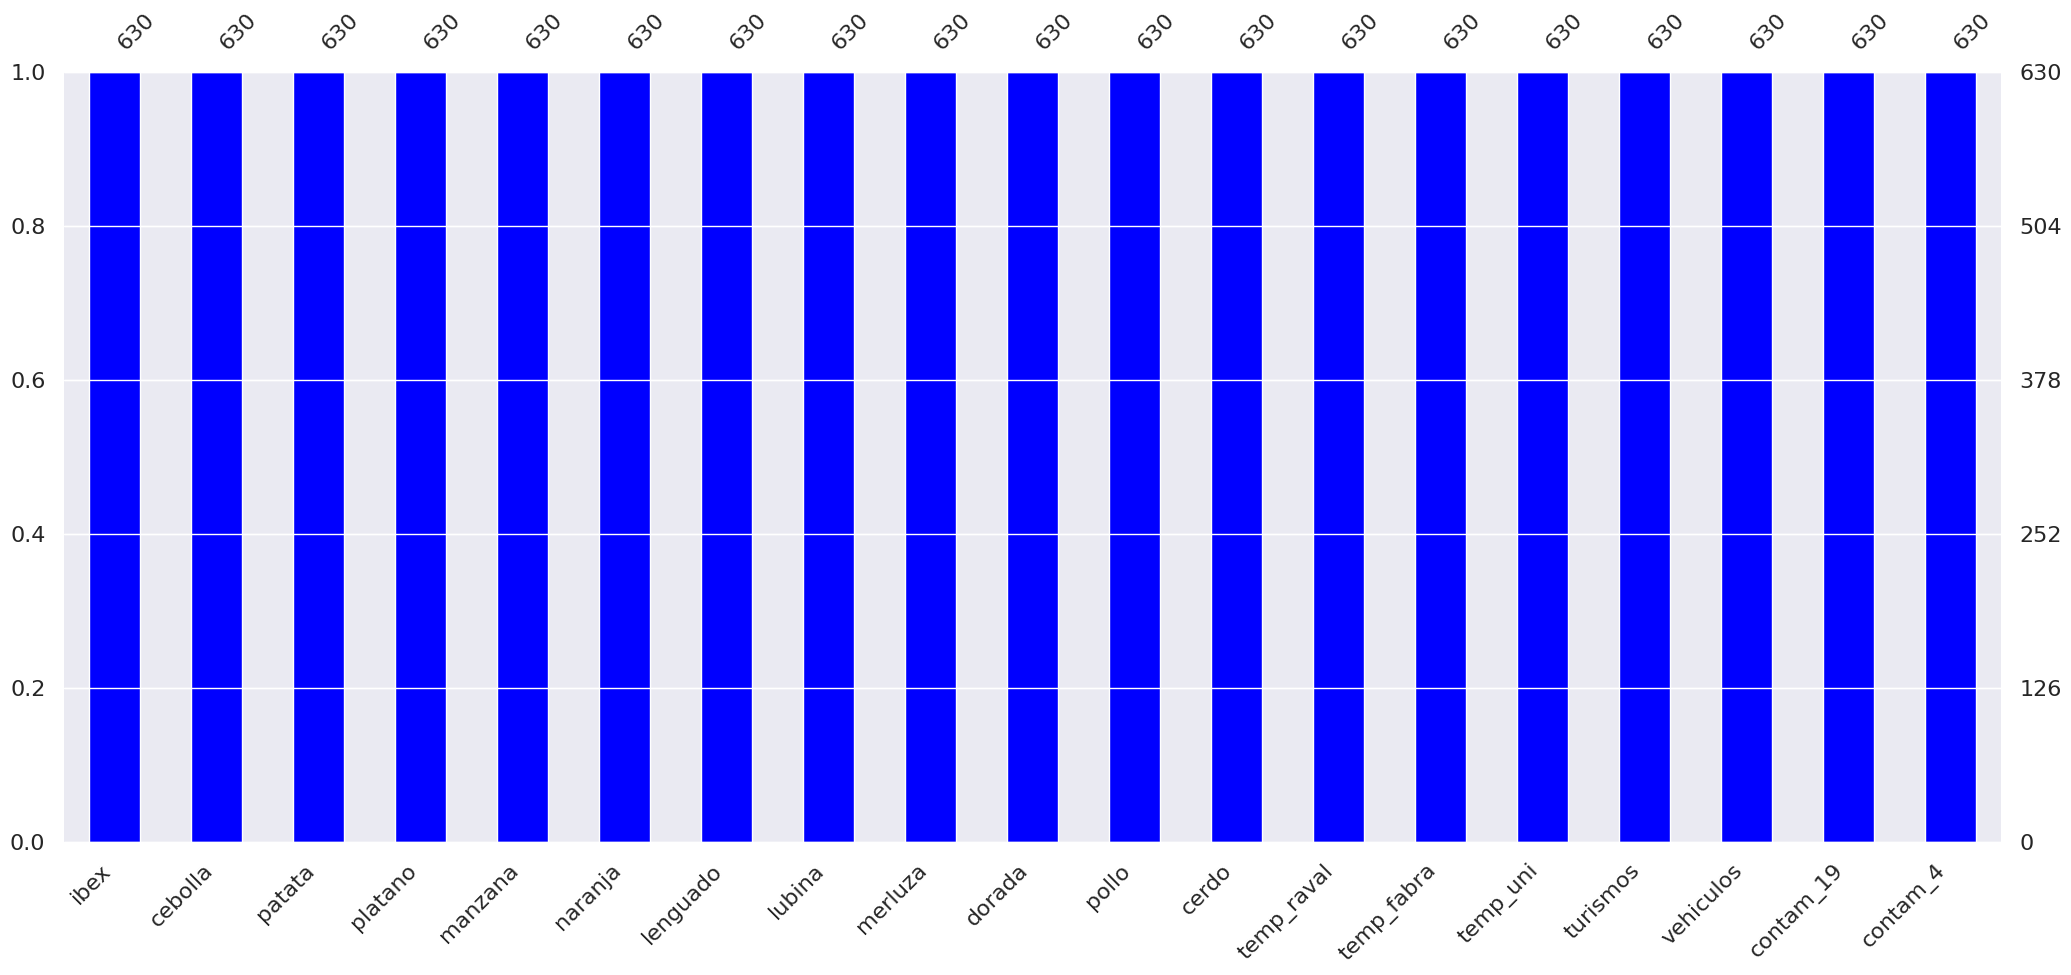

In [9]:
import missingno as msno
msno.bar(BCN_precios_data, color="blue")

Vemos como no tenemos valores perdidos.

## Apartado a

Dividid el conjunto de datos en entrenamiento y test (60 %/40 %). Haced una exploración
mínima del conjunto de datos de entrenamiento observando las relaciones entre las variables, especialmente con la variable objetivo. Describid las cosas que hayáis visto que
os parezcan interesantes. Transformad las variables adecuadamente para poder ajustar un
modelo de regresión tanto el conjunto de entrenamiento como el de test.


Usaremos dos particiones de datos (entrenamiento y prueba) con validación cruzada sobre la partición de entrenamiento para decidir los hiperparámetros.

In [10]:
X = BCN_precios_data.loc[:,BCN_precios_data.columns != 'ibex']
y = BCN_precios_data['ibex']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)

Se nos pide hacer una exploración mínima del conjunto de datos de entrenamiento, así que empezaremos observando la relación entre las diferentes
variables calculando funciones estadísticas que nos indiquen las relaciones
que pueden tener entre ellas, por ejemplo su correlación:

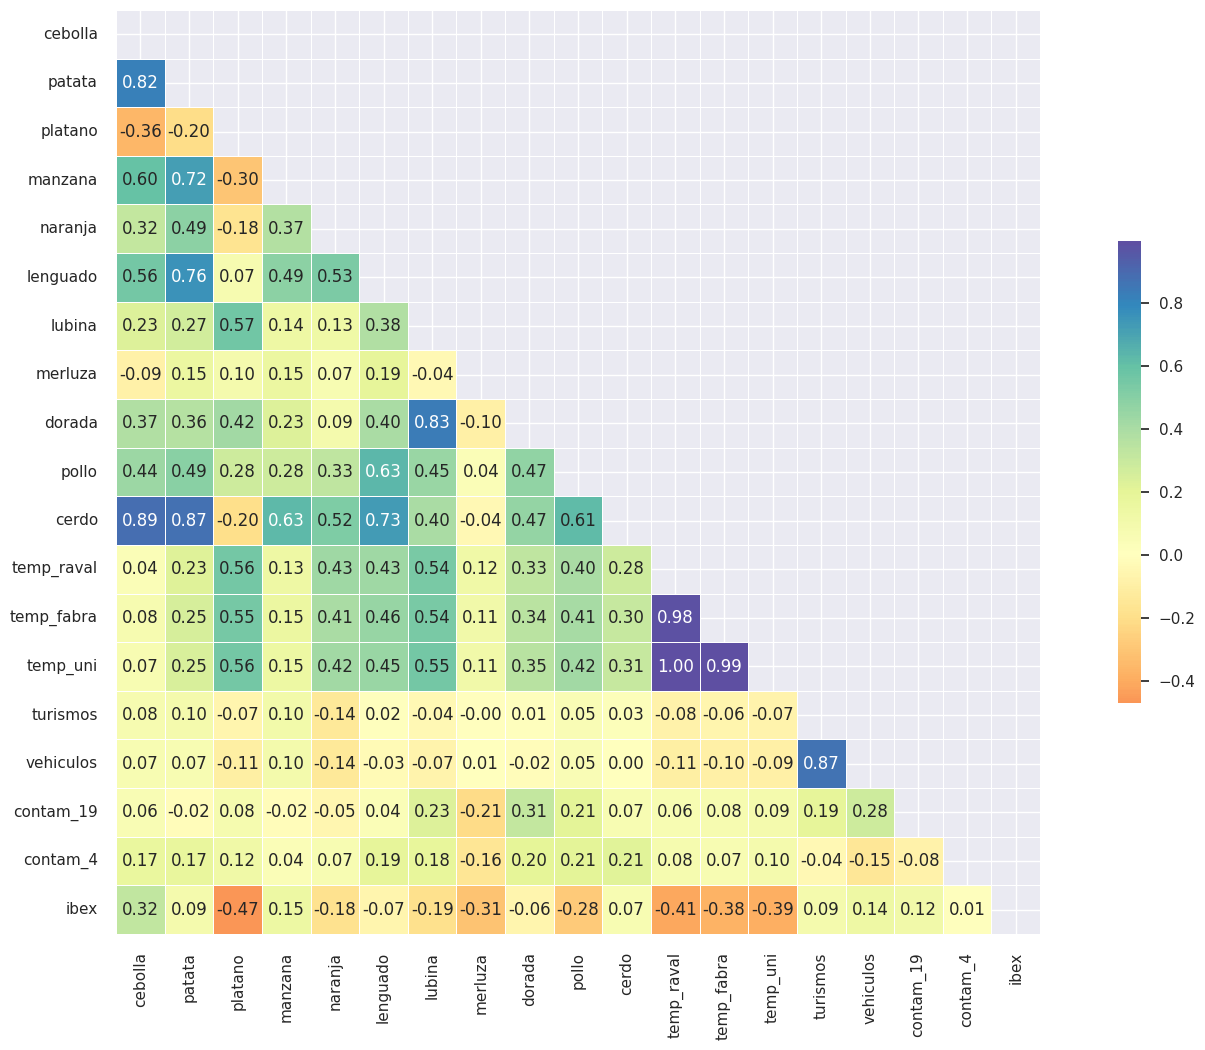

In [11]:
# Vamos a generar un heatmap de la matriz de correlacion del conjunto de entrenamiento
train_data = X_train.copy()
train_data['ibex'] = y_train
corr = train_data.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(20, 12))
sns.heatmap(corr, mask=mask, cmap='Spectral',  center=0, square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5}, fmt=".2f");


Podemos ver como no hay niguna correlación fuerte evidente entre el IBEX y nuestras variables. De hecho, vemos como predominan las correlaciones negativas, sobre  todo con las temperaturas y el precio del plátano. Luego, también podemos ver como los precios de las carnes y frutas tienen una correlación positiva fuerte entre ellos. Por otro lado las temperaturas también tienen una correlación positiva muy fuerte entre ellas (casi de 1 todas), cosa que tiene mucho sentido. También hemos visto como hay cierta correlación entre el precio de las frutas/carnes y las temperaturas medias del dia. Por otra parte, tambien vemos que las matriculaciones de vehiculos y las matriculaciones de turismos parecen tener un comportamiento muy similar y podrian aportar informacion redudante al modelo. Finalmente vemos como ni las matriculaciones ni la contaminación acústica tienen correlación a considerar con el IBEX. (aqui se pueden explicar mas cosas...)

Ahora vamos a transformar las variables adecuadamente para poder ajustar un modelo de regresión tanto en el conjunto de entrenamiento como en el de test.

*** Tal vez podriamos decidir fusionar las variables de temperatura en una única, para reducir dimensionalidad ya que tener una correlacion >= 0.98 es practicamente decir que se comportan igual***

Los modelos de regresión lineal no son compatibles con valores faltantes ni con variables categóricas. En nuestro caso no hay problema, ya que no tenemos ni variables categoricas ni valores faltantes. En caso de tenerlos, deberiamos realizar un preprocesado adecuado. Eso implicaria decidir si simplemenye eliminar muestras con faltantes, eliminar dicha variable o tratar de imputar dichos valores con algoritmos como el KNN, y decidir si realizar una recodificación de las variables categoricas (One-hot encoding) o simplemente eliminar esas columnas.

## Apartado b

Aplicad algún método de reducción de dimensionalidad a los datos de entrenamiento y
comentad lo que se pueda apreciar en la visualización. Pensad en qué podéis representar
sobre la transformación.


Como recordatorio, el objetivo de este proceso es:

- Determinar si existen patrones en los datos mediante su inspección en un espacio de dimensionalidad reducida
- Determinar si hay redundancia de los datos
- Obtener un conjunto de datos con menos dimensiones que permita reducir el coste de ajustar un modelo (posiblemente perdiendo interpretabilidad) y/o hacer más evidentes los patrones para la tarea objetivo

### PCA

In [12]:
from sklearn import datasets

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn import set_config
import warnings

set_config(display='text')
warnings.filterwarnings('ignore')
pd.set_option('display.precision', 3)

from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Vamos a usar PCA como método de reducción de dimensionalidad.

PCA se basa en la matriz de covarianza de las variables, asume que los datos estan estandarizados, asi que aplicaremos esa transformación. Esto cambiará los datos para que todas las variables tengan media 0 y desviación estándar 1. Haremos esto con los datos de entrenamiento.

In [13]:
data_standarized = X_train.copy()
data_standarized[:] = StandardScaler().fit_transform(data_standarized[:])
data_standarized.describe().T

,count,mean,std,min,25%,50%,75%,max
cebolla,378.0,-5.169e-17,1.001,-1.272,-1.060,0.067,0.639,2.355
patata,378.0,-7.989e-17,1.001,-1.834,-0.789,0.176,0.578,2.186
platano,378.0,1.574e-16,1.001,-1.362,-0.846,0.015,0.359,2.425
manzana,378.0,-3.055e-17,1.001,-1.403,-0.638,-0.383,0.637,3.696
naranja,378.0,6.955e-16,1.001,-2.847,-0.865,-0.370,0.621,2.975
lenguado,378.0,-7.049e-17,1.001,-1.830,-0.996,0.142,0.611,4.314
lubina,378.0,-1.015e-15,1.001,-2.031,-0.764,-0.131,0.925,1.876
merluza,378.0,7.143e-16,1.001,-2.326,-0.790,-0.022,0.703,3.050
dorada,378.0,-2.961e-16,1.001,-1.788,-0.810,0.046,0.902,2.124
pollo,378.0,5.028e-16,1.001,-2.619,-0.717,0.226,0.763,1.412


El método PCA de scikit-learn devolverá la relación de varianza explicada y todos los parámetros importantes relacionados con PCA.

Se puede usar la relación de varianza explicada y los valores singulares para decidir cuántos componentes conservar.

In [14]:
myPCA = PCA().fit(data_standarized[:]);

print(myPCA.explained_variance_ratio_)
print(myPCA.explained_variance_ratio_.cumsum())

[3.35650635e-01 1.82321103e-01 1.15909839e-01 9.14466766e-02
 5.84422191e-02 5.43638236e-02 3.92152300e-02 3.05058414e-02
 2.54707134e-02 2.00039308e-02 1.58312788e-02 8.85302846e-03
 7.12544817e-03 6.47342850e-03 4.54195408e-03 2.76201954e-03
 9.57822047e-04 1.25008214e-04]
[0.33565064 0.51797174 0.63388158 0.72532825 0.78377047 0.8381343
 0.87734953 0.90785537 0.93332608 0.95333001 0.96916129 0.97801432
 0.98513977 0.9916132  0.99615515 0.99891717 0.99987499 1.        ]


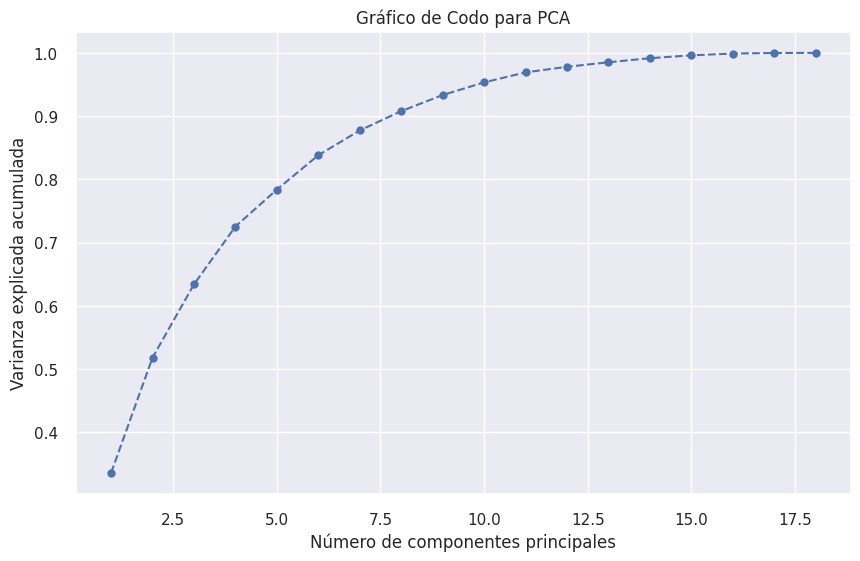

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(myPCA.explained_variance_ratio_) + 1), np.cumsum(myPCA.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Gráfico de Codo para PCA')
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada acumulada')
plt.grid(True)
plt.show();

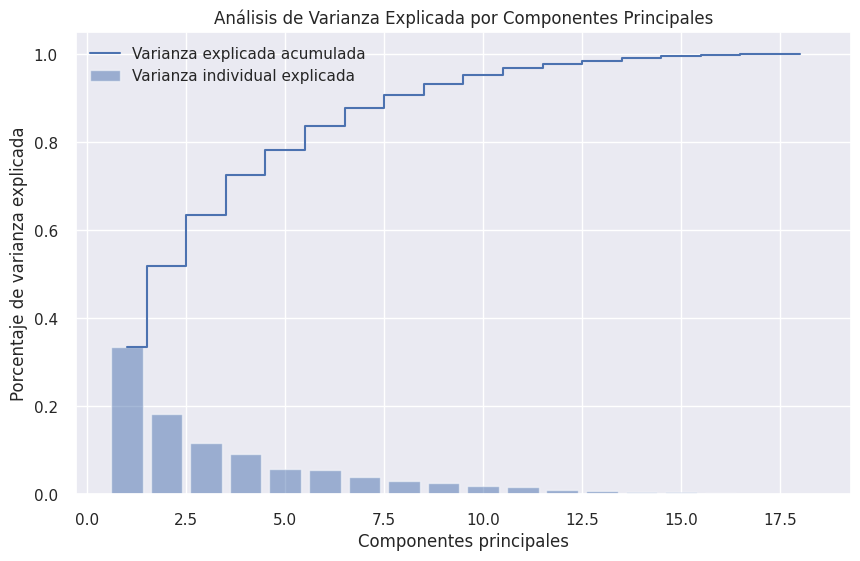

In [16]:
explained_variance = myPCA.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Varianza individual explicada')
plt.step(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), where='mid', label='Varianza explicada acumulada')
plt.xlabel('Componentes principales')
plt.ylabel('Porcentaje de varianza explicada')
plt.legend(loc='best')
plt.title('Análisis de Varianza Explicada por Componentes Principales')
plt.show();

Podemos visualizar también los pesos que le asigna el PCA a cada componente

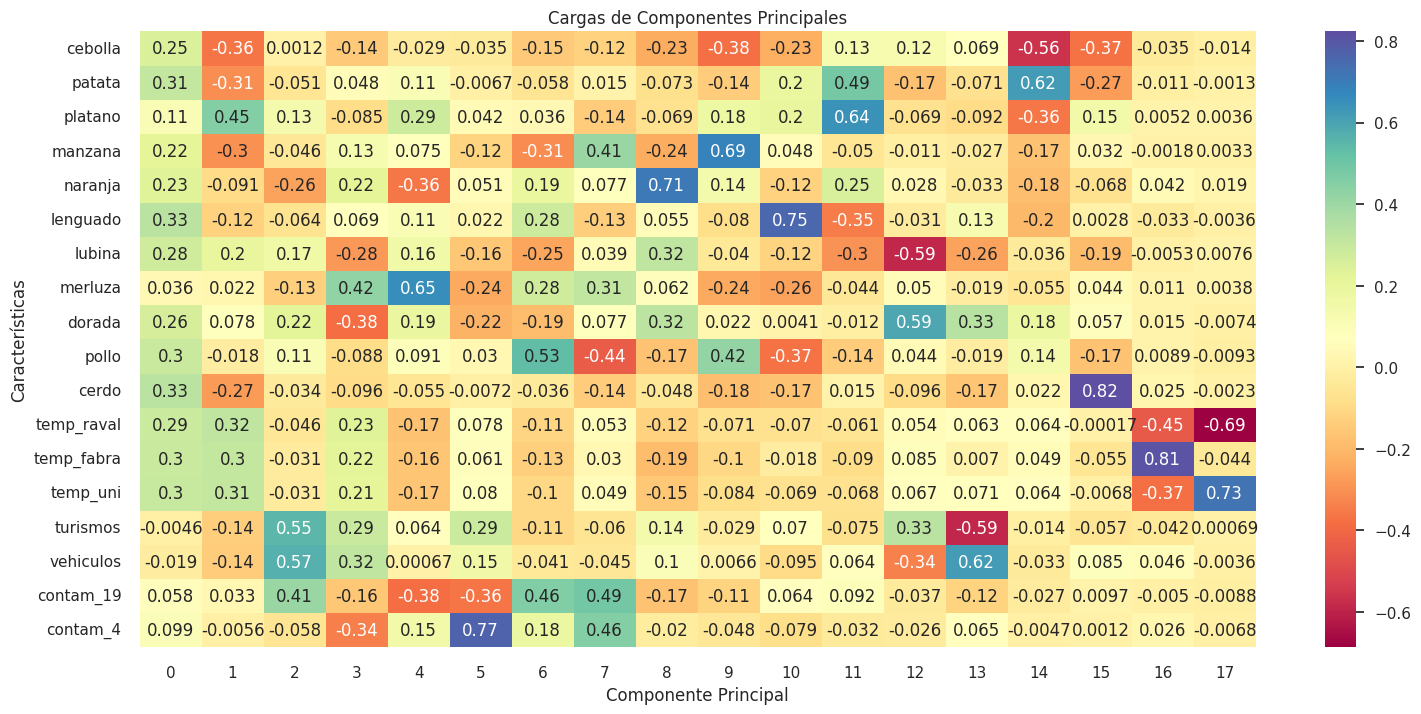

In [17]:
plt.figure(figsize=(18, 8))
components = pd.DataFrame(myPCA.components_, columns=features.columns)
sns.heatmap(components.T, cmap='Spectral', annot=True)
plt.title('Cargas de Componentes Principales')
plt.xlabel('Componente Principal')
plt.ylabel('Características')
plt.show();

Una vez aplicado PCA a nuestros datos, mediante:
- El gráfico de Codo y el análisis de Varianza Explicada Acumulada, podemos ver que si cojemos las 9 principales componentes estariamos reduciendo la dimensionalidad de nuestras variables practicamente a la mitad y ya obtendriamos mas de un 90% de la varianza explicada
- Por otra parte si mostramos el gráfico de los pesos de las componentes podemos ver que variables tiene mas en cuenta cada componente, por ejemplo:
  - si nos fijamos en la primera componente, vemos que tiene en cuenta todas aquellas variables que hacen referencia a la comida y a la temperatura
  - si nos fijamos en la segunda componente vemos que se centra mas en las frutas y en la temperatura indicandonos que de los datos se puede sacar una gran varianza discriminando al plátano de las demas frutas
  - si nos fijamos en la tercera componente, vemos como claramente se podria clasifcar como una variable que hace referencia al tránsito ya que tiene en cuenta las matriculaciones de los turismos y de los vehiculos y la contaminacion a la tarde, aunque no incluye la contaminación a las 4.
  - si vamos mas adelante y nos fijamos en la quinta componente vemos que le da una gran importancia a la lubina positivamente y a la naranja y a la contaminacion de las 19 negativamente.




### T-SNE

Visto que con PCA no obtenemos muy buenos resultados para ser visualizados en 2 o 3 dimensiones, procedemos a aplicar t-sne para obtener una representacion gráfica en 2 o 3 dimensiones.

TSNE transforma las distancias entre puntos en probabilidades y luego trata de mantener las mismas distribuciones de probabilidad mientras transforma los datos a un espacio dimensional del numero de dimensiones que se le especifique.

Depende de la inicialización y su resultado puede cambiar entre ejecuciones, también depende **fuertemente** de sus parámetros.

Los parámetros más importantes de este modelo son:
* Perplejidad: Equilibra la atención entre los aspectos locales y globales de los datos. Por lo general, estará entre 5 y 50 y tiene un efecto muy fuerte en la visualización final.
* Número de iteraciones.


Hacemos primero una visualizacion en 2D, para eso tenemos que hacer una busqueda de cuales son los mejores valores que pueden cojer los dos parámetros del modelo.

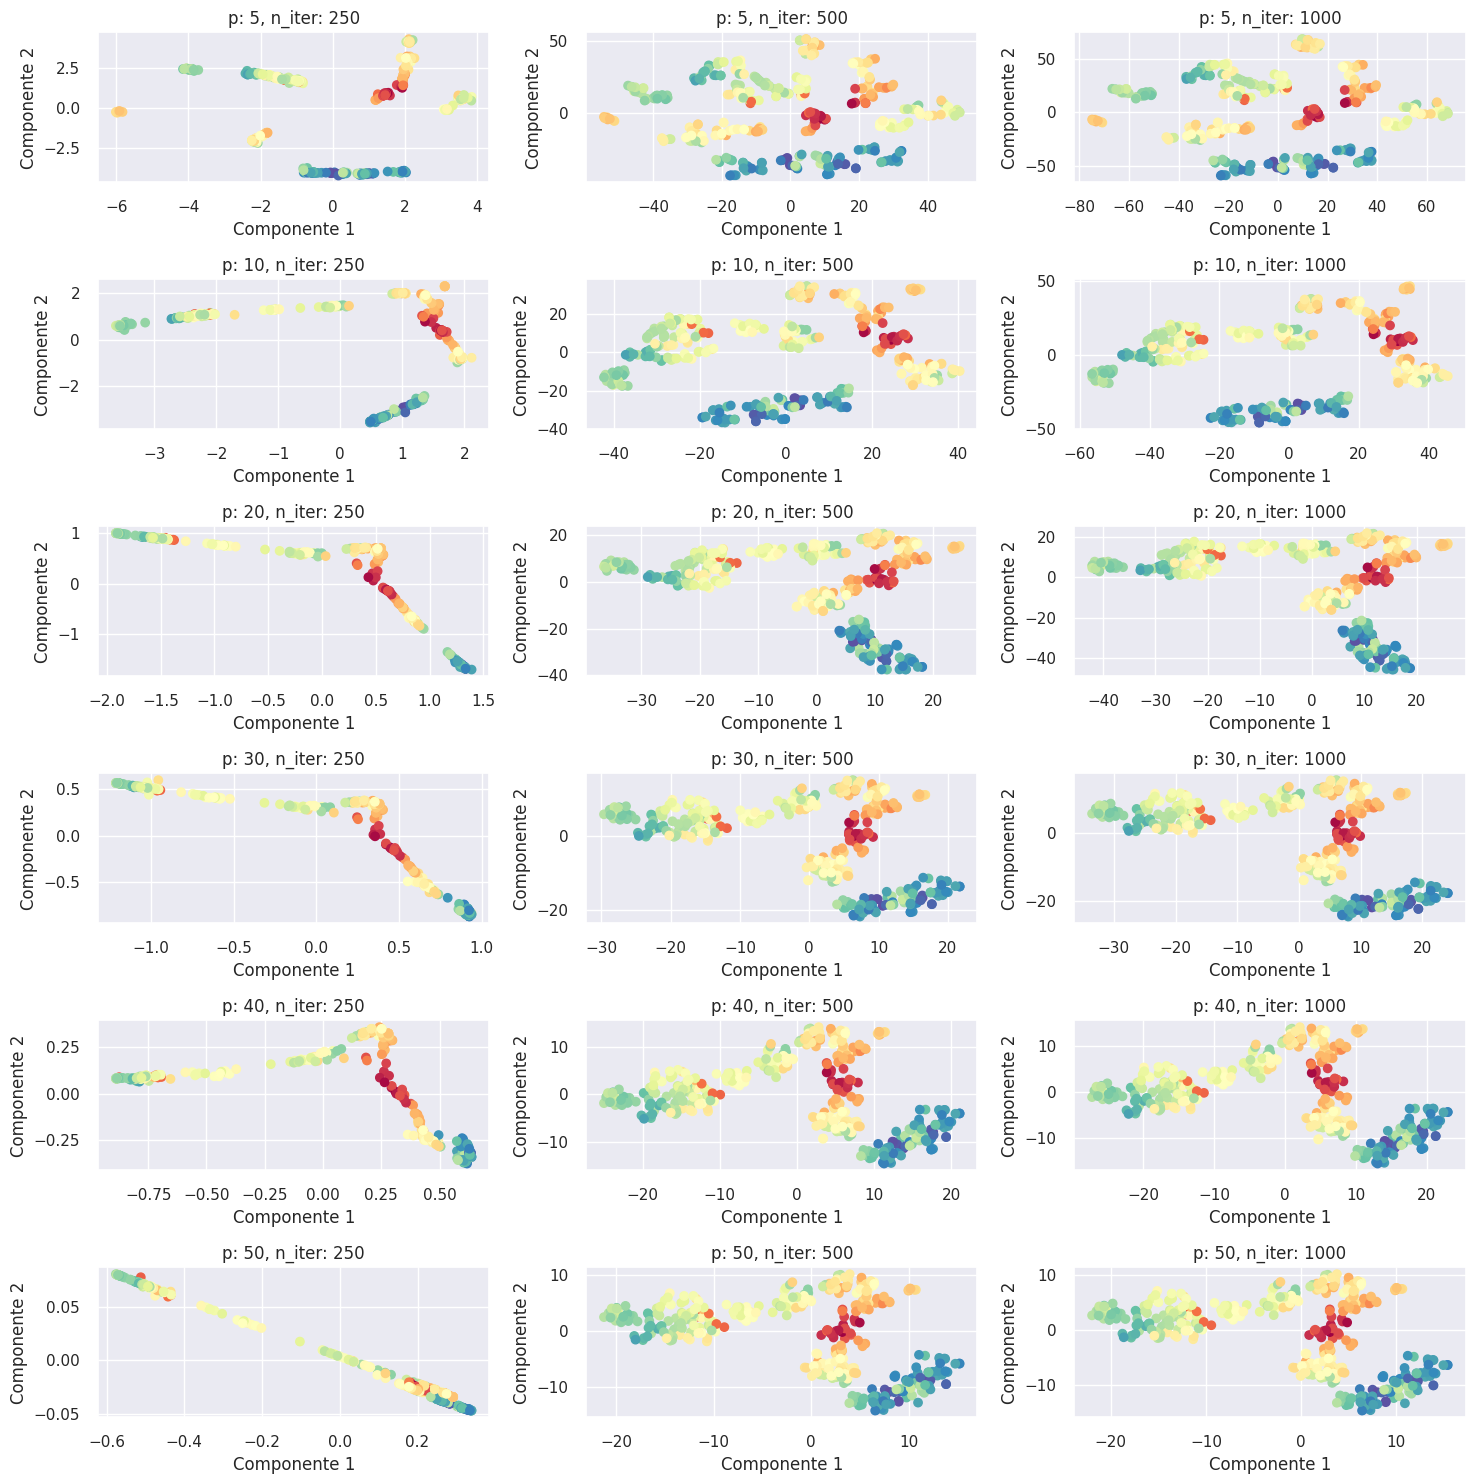

In [18]:
from sklearn.manifold import TSNE

perplexity_values = [5, 10, 20, 30, 40, 50]
n_iter_values = [250, 500, 1000]

fig, axes = plt.subplots(len(perplexity_values), len(n_iter_values), figsize=(15, 15))

for i, perplexity in enumerate(perplexity_values):
    for j, n_iter in enumerate(n_iter_values):

        tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42)
        data_tsne = tsne.fit_transform(data_standarized)

        ax = axes[i, j]
        ax.scatter(data_tsne[:, 0], data_tsne[:, 1], cmap = 'Spectral', c=y_train)
        ax.set_xlabel('Componente 1')
        ax.set_ylabel('Componente 2')
        ax.set_title(f'p: {perplexity}, n_iter: {n_iter}')

plt.tight_layout();
plt.show();

Una vez mostradas las distintas agrupaciones obtenidas con las distintas combinaciones de valores de los parámetros, seleccionamos los que nos dan unos resultados más separables. (Hay que tener en cuenta que el t-sne es estocástico y cada ejecución podemos obtener valores un poco distintos, )

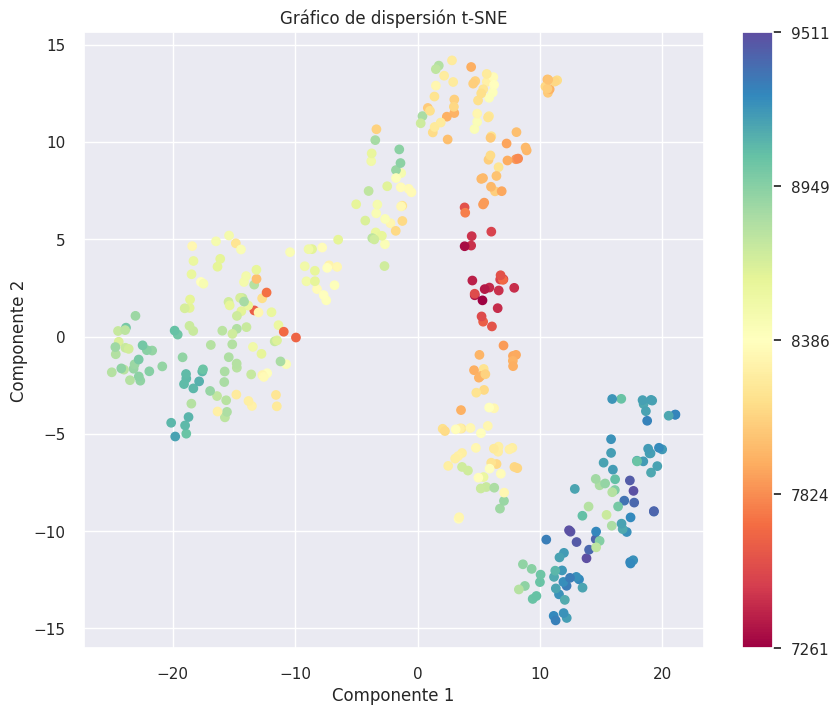

In [19]:
best_perplexity = 40
best_n_iter = 500

tsne = TSNE(n_components=2, perplexity=best_perplexity, n_iter=best_n_iter, random_state=42)

data_tsne = tsne.fit_transform(data_standarized)

plt.figure(figsize=(10, 8))
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], cmap = 'Spectral', c=y_train)
plt.colorbar(ticks=np.linspace(y_train.min(), y_train.max(), 5))
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.title('Gráfico de dispersión t-SNE')
plt.show();

Hacemos ahora una visualización en 3d

In [20]:
import plotly.express as px

tsne = TSNE(n_components=3, perplexity=best_perplexity, n_iter=best_n_iter, random_state=42)

data_tsne = tsne.fit_transform(data_standarized)

fig = px.scatter_3d(x=data_tsne[:, 0], y=data_tsne[:, 1], z=data_tsne[:, 2], color=y_train, color_continuous_scale='Spectral')
fig.update_layout(scene=dict(xaxis_title='Componente 1', yaxis_title='Componente 2', zaxis_title='Componente 3'))

Una vez aplicado t-sne al conjunto de datos, vemos que obtenemos una gran separabilidad en los precios con valores que se encuentran cerca del máximo y cerca del mínimo, vemos como los valores mas grandes que 9000 se concentran en un grupo y los valores mas pequeños que 8000 se concentran tambien en otro grupo.

Ahora bien, vemos por otra parte que los precios que se encuentran entre 8000 y 9000 se encuentran un poco dispersos entre ellos, es decir vemos como colores cercanos a 8500 se distribuyen en distintos clusters pequeños (con los valores cercanos a 9000, el comportamiento es parecido).


## Apartado c
Ajustad una regresión lineal, una regresión Ridge y una regresión LASSO a los datos ¿Os
parece suficientemente bueno el resultado? Representad los valores de la variable objetivo
para el conjunto de test contra las predicciones y representad los residuos. ¿Qué modelo
os parece mejor?

Usaremos cross-validation para los tres modelos.

También podemos usar la función de statsmodels

In [21]:
# Linear regression se llama ordinary least squares (OLS) en statsmodels
model = sm.OLS(y_train, sm.add_constant(X_train))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   ibex   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     24.18
Date:                Sun, 27 Oct 2024   Prob (F-statistic):           3.41e-51
Time:                        18:22:05   Log-Likelihood:                -2738.9
No. Observations:                 378   AIC:                             5516.
Df Residuals:                     359   BIC:                             5591.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7148.8190   1322.695      5.405      0.000    4547.616    9750.022
cebolla     1355.6312    177.218      7.650      0.000    1007.116    1704.146
patata      -281.9930    411.510     -0.685      0.494   -1091.265     527.279
platano     -262.0763     69.993     -3.744      0.000    -399.724    -124.429
manzana      245.0135    139.376      1.758      0.080     -29.082     519.109
naranja     -352.9395    144.637     -2.440      0.015    -637.382     -68.497
lenguado      66.4537     12.978      5.121      0.000      40.932      91.975
lubina       176.3408     85.845      2.054      0.041       7.518     345.164
merluza     -158.5288     27.161     -5.837      0.000    -211.943    -105.115
dorada       -58.2221     94.830     -0.614      0.540    -244.714     128.270
pollo       -995.9966    194.860     -5.111      0.000   -1379.207    -612.786
cerdo      -1099.1015    203.830     -5.392      0.000   -1499.953    -698.250
temp_raval   -63.9311     46.930     -1.362      0.174    -156.224      28.362
temp_fabra     8.9590     18.113      0.495      0.621     -26.662      44.580
temp_uni      45.0955     46.908      0.961      0.337     -47.154     137.345
turismos      -1.8526      1.035     -1.791      0.074      -3.887       0.182
vehiculos      1.4158      0.723      1.958      0.051      -0.006       2.838
contam_19     40.7318     18.544      2.196      0.029       4.263      77.201
contam_4      12.0862      8.634      1.400      0.162      -4.893      29.065
==============================================================================
Omnibus:                        1.793   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.408   Jarque-Bera (JB):                1.579
Skew:                           0.012   Prob(JB):                        0.454
Kurtosis:                       2.684   Cond. No.                     1.28e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
# También usamos validación cruzada en este modelo, usando la media de las particiones
# como nuestra métrica
lr = LinearRegression().fit(X_train,y_train);
folds_r2 = cross_val_score(lr, X_train,y_train, cv=5, scoring='r2')
lr_r2 = np.mean(folds_r2)
folds_r2, lr_r2

(array([0.41735233, 0.63387457, 0.45424043, 0.36659405, 0.42937133]),
 0.4602865428436388)

Distribución de los residuos:

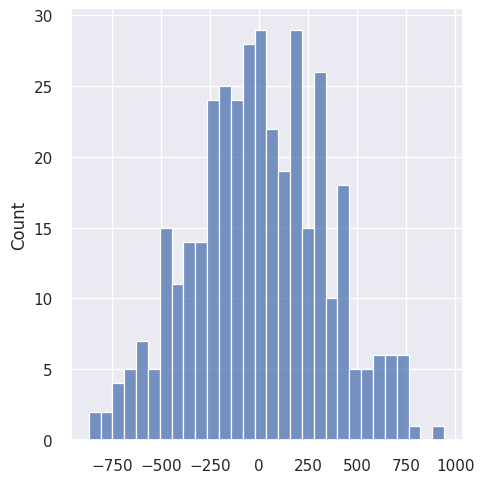

In [23]:
sns.displot(result.resid,bins=30);

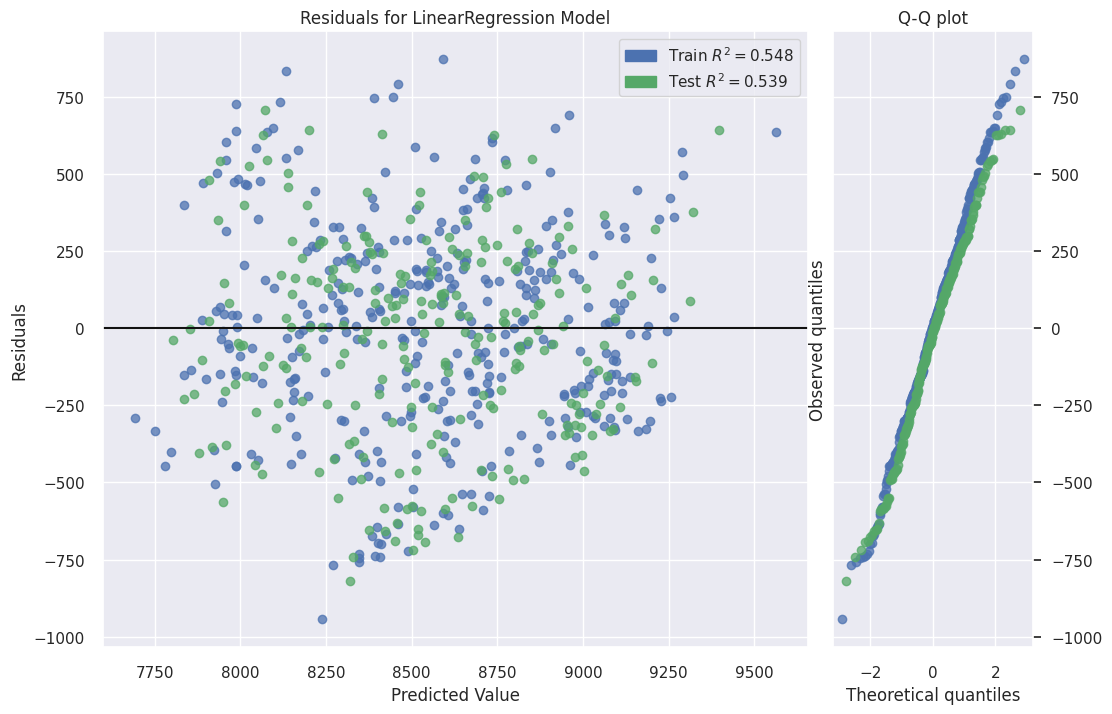

In [24]:
from yellowbrick.regressor import residuals_plot
plt.figure(figsize=(12,8));
viz = residuals_plot(lr, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False);

Vemos las predicciones respecto a los valores reales y cuanto se desvían de la predicción ideal

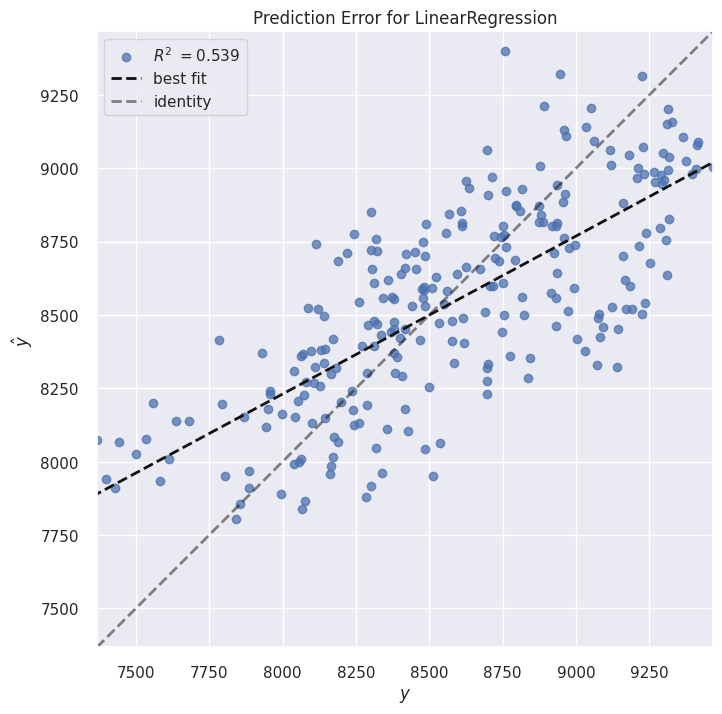

In [25]:
from yellowbrick.regressor import prediction_error

plt.figure(figsize=(8,8))
visualizer = prediction_error(lr, X_test, y_test, is_fitted=True);

#### Regresión lineal RIDGE

In [26]:
lambdas = [1e-4,1e-3,1e-2,0.1, 0.5,1,5,10,50,100]
ridge_cv = RidgeCV(alphas=lambdas,cv=5).fit(X_train,y_train)

print(f'Best lambda: {ridge_cv.alpha_} R2 score: {ridge_cv.best_score_:3.3f}')

Best lambda: 0.5 R2 score: 0.462


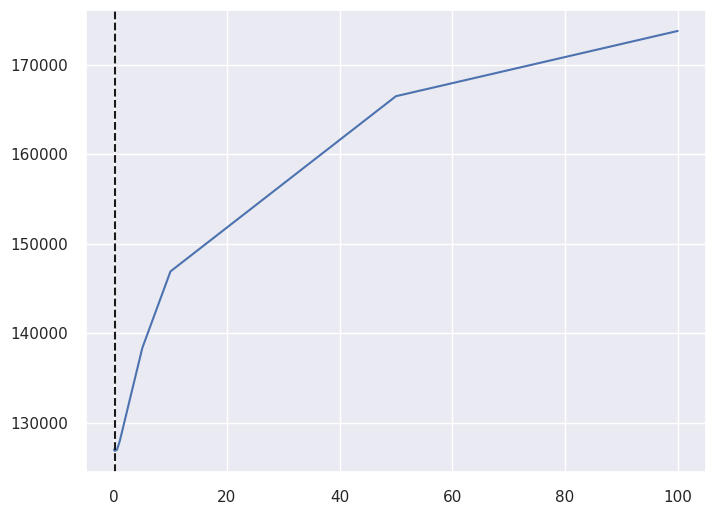

In [27]:
plt.figure(figsize=(8,6))
vis = AlphaSelection(RidgeCV(alphas=lambdas));
vis.fit(X_train, y_train);

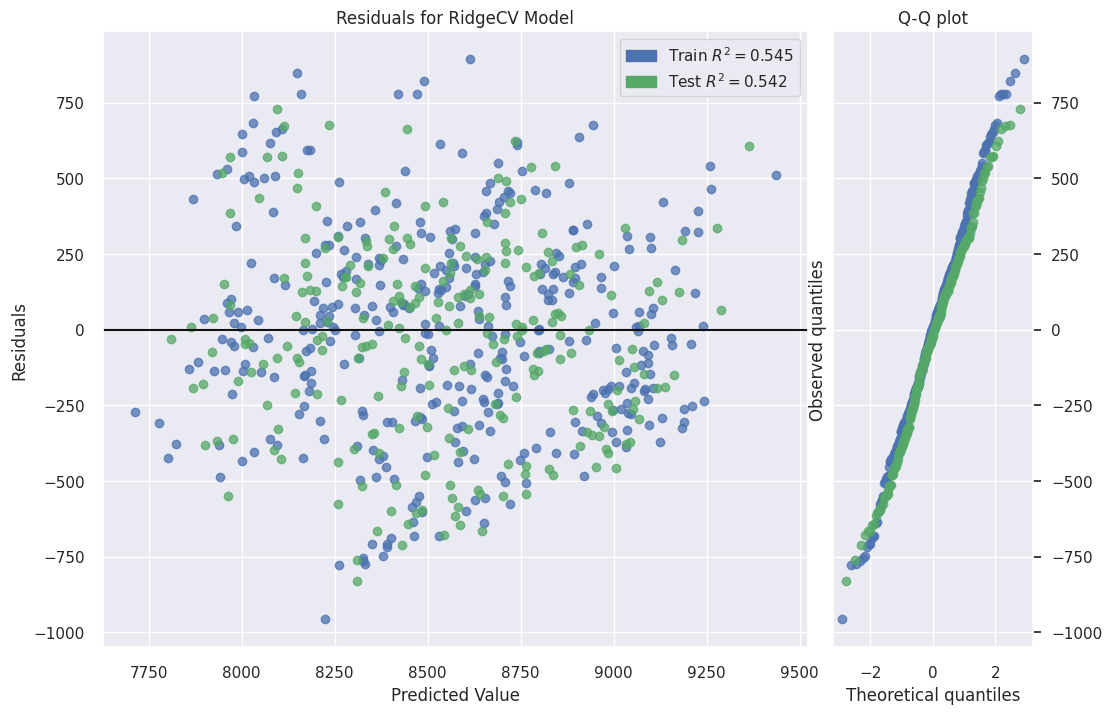

In [28]:
plt.figure(figsize=(12,8));
viz = residuals_plot(ridge_cv, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False);

<Figure size 800x800 with 0 Axes>

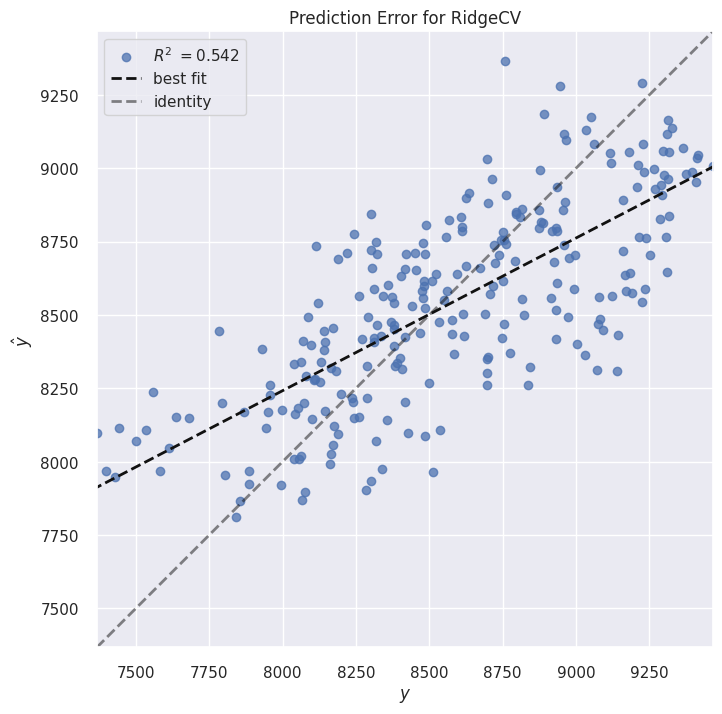

In [29]:
plt.figure(figsize=(8, 8))
visualizer = prediction_error(ridge_cv, X_test, y_test, is_fitted=True)

#### Regresión lineal LASSO

In [30]:
lasso_cv = LassoCV(alphas=lambdas,cv=5).fit(X_train,y_train)

lasso_r2 =  np.mean(cross_val_score(lasso_cv, X_train,y_train))

print('Best lambda:', lasso_cv.alpha_, 'R2 score:',lasso_r2)

Best lambda: 1.0 R2 score: 0.4582132633455463


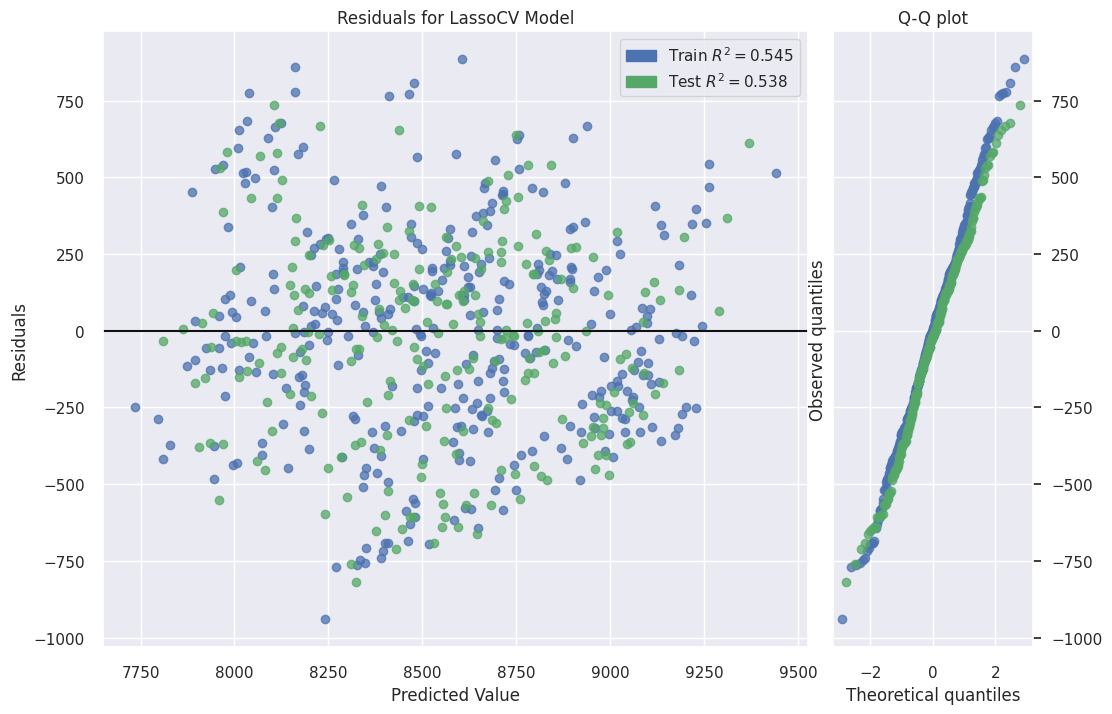

In [31]:
plt.figure(figsize=(12,8));
viz = residuals_plot(lasso_cv, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False);

<Figure size 800x800 with 0 Axes>

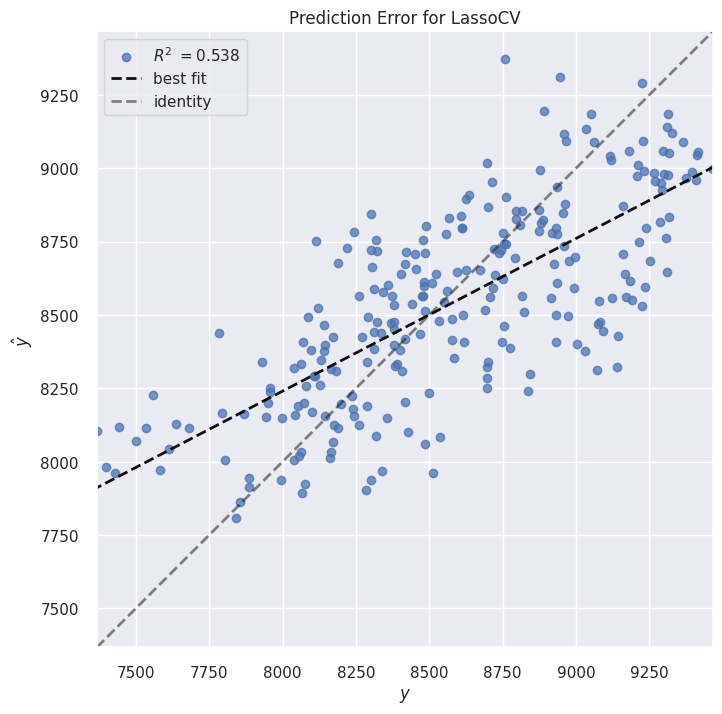

In [32]:
plt.figure(figsize=(8, 8))
visualizer = prediction_error(lasso_cv, X_test, y_test, is_fitted=True)

Los resultados finales que hemos observado son:

In [33]:
r2_results = pd.DataFrame({'lr':lr_r2, 'ridge_cv':ridge_cv.best_score_, 'lasso_cv':lasso_r2},index=['CV R2'])

r2_results.loc['Train R2', :] =[r2_score(y_train,lr.predict(X_train)),
                                r2_score(y_train,ridge_cv.predict(X_train)),
                                r2_score(y_train,lasso_cv.predict(X_train))]
r2_results.loc['lambda','lr']=0
r2_results.loc['lambda','ridge_cv']=ridge_cv.alpha_
r2_results.loc['lambda','lasso_cv']=lasso_cv.alpha_
r2_results

,lr,ridge_cv,lasso_cv
CV R2,0.460,0.462,0.458
Train R2,0.548,0.545,0.545
lambda,0.000,0.500,1.000


Vemos que los resultados son muy malos. El coeficiente de determinación nos indica que el modelo no se ajusta muy bien a los datos.

## Apartado d

Comprobad si el modelo LASSO identifica las variables espurias como no significativas.
Eliminadlas del modelo y volved a ajustar el mejor modelo que os ha salido ¿Cuál es el
mejor? Comentad los resultados.


Para comprovar esto, vamos a ver los pesos de nuestros tres modelos.

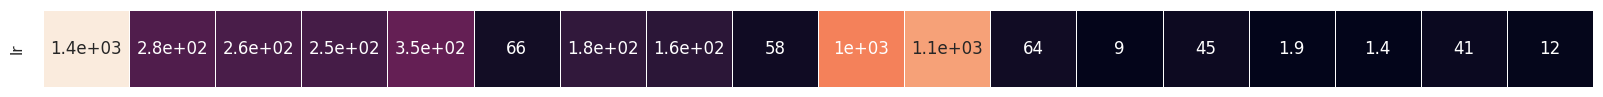

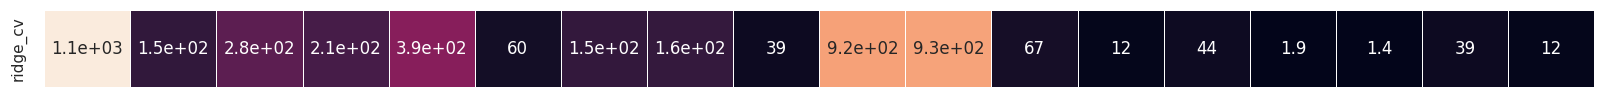

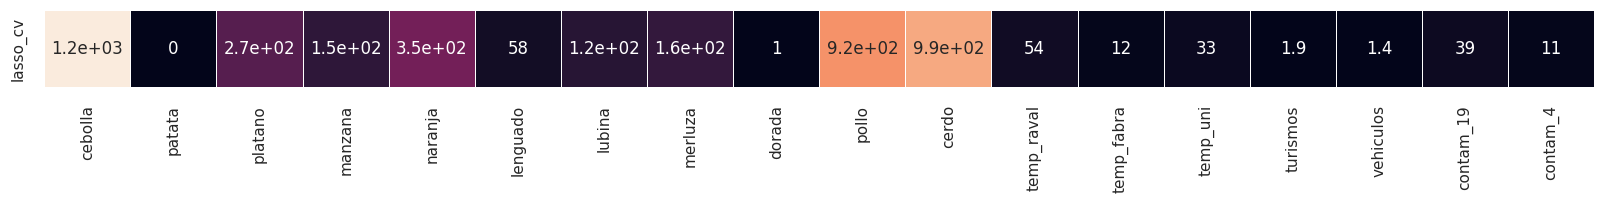

In [34]:
weights = pd.DataFrame({'lr':lr.coef_, 'ridge_cv':ridge_cv.coef_, 'lasso_cv':lasso_cv.coef_},index=X_train.columns)

fig,  ax = plt.subplots( figsize = (20,1));
sns.heatmap(weights.T.loc[['lr'],:].abs(),annot=True, linewidths=.5,ax=ax,cbar=False,xticklabels=False);

plt.figure(figsize = (20,1));
sns.heatmap(weights.T.loc[['ridge_cv'],:].abs(),annot=True, linewidths=.5,cbar=False,xticklabels=False);

plt.figure(figsize = (20,1));
sns.heatmap(weights.T.loc[['lasso_cv'],:].abs(),annot=True, linewidths=.5,cbar=False,xticklabels=True);

Vemos que LASSO no identifica las variables espurias como no significativas. De hecho, les asocia un peso muy elevado. Previamente vimos que algunas variables espurias estaban bsatante correlacionadas con otras variables explicativas que sí son relevantes, y el modelo puede interpretar erróneamente esa correlación como una relación directa con la variable objetivo. Vamos a eliminar dichas variables (temperaturas y ruido), para ver si obtenemos un mejor modelo.

In [35]:
X_train_2 = X_train.drop(columns=['temp_raval', 'temp_fabra', 'temp_uni', 'contam_4', 'contam_19'])
X_test_2 = X_test.drop(columns=['temp_raval', 'temp_fabra', 'temp_uni', 'contam_4', 'contam_19'])


In [36]:
lasso_cv = LassoCV(alphas=lambdas,cv=5).fit(X_train_2,y_train)

lasso_r2 =  np.mean(cross_val_score(lasso_cv, X_train_2,y_train))

print('Best lambda:', lasso_cv.alpha_, 'R2 score:',lasso_r2)

Best lambda: 1.0 R2 score: 0.4692379754753334


<Figure size 800x800 with 0 Axes>

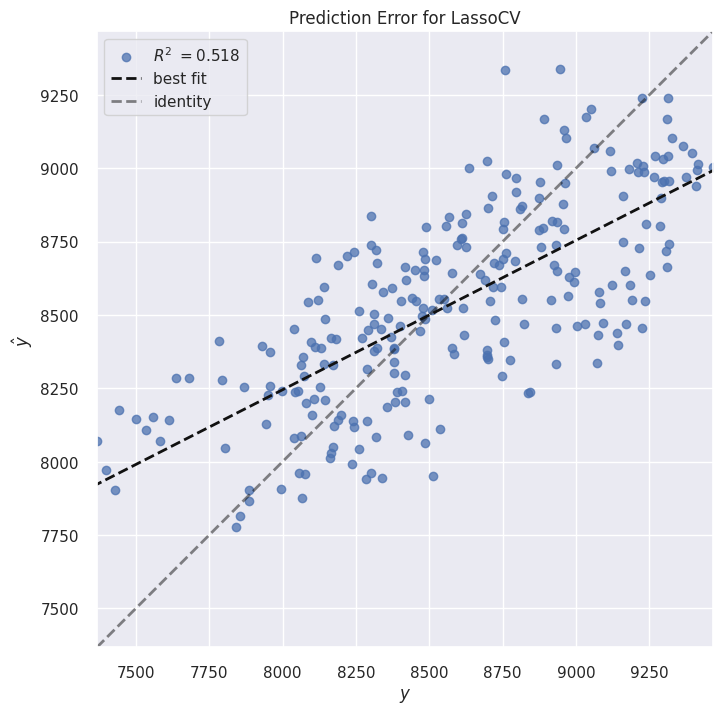

In [37]:
plt.figure(figsize=(8, 8))
visualizer = prediction_error(lasso_cv, X_test_2, y_test, is_fitted=True)

<Figure size 2000x100 with 0 Axes>

<Axes: >

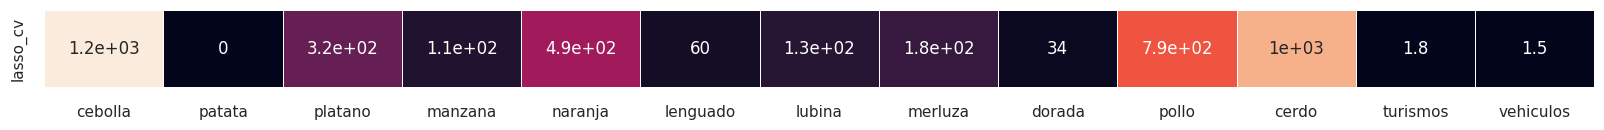

In [38]:
lasso_weights = pd.DataFrame({'lasso_cv': lasso_cv.coef_}, index=X_train_2.columns)

# Visualizar los coeficientes con un heatmap
plt.figure(figsize=(20, 1))
sns.heatmap(lasso_weights.T.abs(), annot=True, linewidths=.5, cbar=False, xticklabels=True)

Eliminando las variables espurias no hemos mejorado. De hecho, aunque sea malo, el modelo anterior era mejor.

## Apartado e
Otra manera de ver la relevancia de las variables en el modelo es comprobar la significatividad de los coeficientes de regresión. Ajustad una regresión lineal con todas las variables
usando el método OLS de la librería statsmodels (los pesos serán los mismos que en la
regresión lineal) y analizad la significatividad que asigna el método al coeficiente de cada
variable. Explicad lo que habéis visto ¿hay alguna posible razón para que algunas variables
no sean importantes? Eliminad las variables que no son significativas y ajustad de nuevo
el mejor modelo. Comentad los resultados.

In [39]:
# Ajustamos el modelo de regresión lineal con OLS
ols_model = sm.OLS(y_train, X_train).fit()

# Mostramos el resumen del modelo
print(ols_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                   ibex   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          1.179e+04
Date:                Sun, 27 Oct 2024   Prob (F-statistic):                        0.00
Time:                        18:22:13   Log-Likelihood:                         -2753.7
No. Observations:                 378   AIC:                                      5543.
Df Residuals:                     360   BIC:                                      5614.
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Como vimos en la sesión de laboratorio, si el valor de p es menor a un umbral (generalmente 0.05), podemos decir que la variable es relevante para predecir el objetivo. Por lo tanto, asumimos como variables NO significativas aquellas con un valor de p superior a 0.05. Además, en el summary del modelo OLS vemos también el coeficiente t, que evalua la significatividad estadística de cada coeficiente respecto la variable objetivo. Valores de t cercanos a cero indican no relevancia, y valores grandes indican que la variable tiene un efecto importante. En conclusión, las variables no significativa són:
- patata
- dorada
- temp_raval
- temp_fabra
- temp_uni
- turismos
- vehiculos

Vamos a ajusar de nuevo las tres regresiones pero ahora sin tener en cuenta las variables determinadas como no significativas

In [40]:
X_train_2 = X_train.drop(columns=['temp_raval', 'temp_fabra', 'temp_uni', 'patata', 'dorada', 'turismos', 'vehiculos'])
X_test_2 = X_test.drop(columns=['temp_raval', 'temp_fabra', 'temp_uni', 'patata', 'dorada', 'turismos', 'vehiculos'])


In [41]:
lr = LinearRegression().fit(X_train_2,y_train);
folds_r2 = cross_val_score(lr, X_train_2,y_train, cv=5, scoring='r2')
lr_r2 = np.mean(folds_r2)
folds_r2, lr_r2

(array([0.44784784, 0.62581713, 0.44118451, 0.3972989 , 0.48943262]),
 0.48031620165990574)

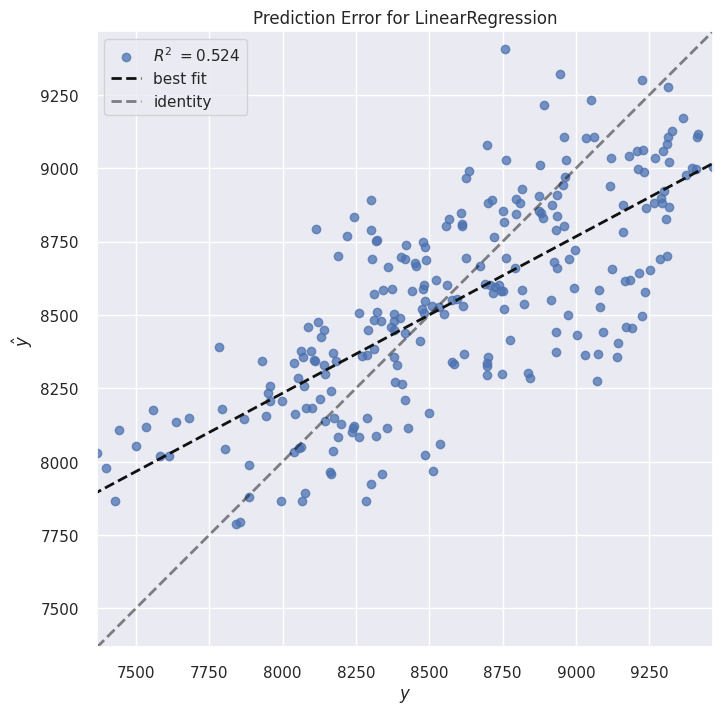

In [42]:
from yellowbrick.regressor import prediction_error

plt.figure(figsize=(8,8))
visualizer = prediction_error(lr, X_test_2, y_test, is_fitted=True);

In [43]:
lambdas = [1e-4,1e-3,1e-2,0.1, 0.5,1,5,10,50,100]
ridge_cv = RidgeCV(alphas=lambdas,cv=5).fit(X_train_2,y_train)

print(f'Best lambda: {ridge_cv.alpha_} R2 score: {ridge_cv.best_score_:3.3f}')

Best lambda: 0.1 R2 score: 0.481


<Figure size 800x800 with 0 Axes>

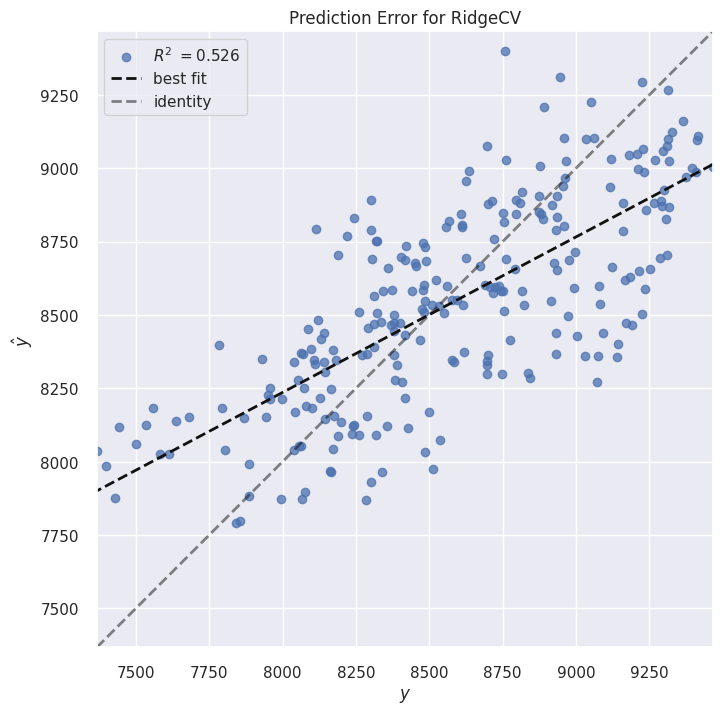

In [44]:
plt.figure(figsize=(8, 8))
visualizer = prediction_error(ridge_cv, X_test_2, y_test, is_fitted=True)

In [45]:
lasso_cv = LassoCV(alphas=lambdas,cv=5).fit(X_train_2,y_train)

lasso_r2 =  np.mean(cross_val_score(lasso_cv, X_train_2,y_train))

print('Best lambda:', lasso_cv.alpha_, 'R2 score:',lasso_r2)

Best lambda: 0.1 R2 score: 0.4805057783555764


<Figure size 800x800 with 0 Axes>

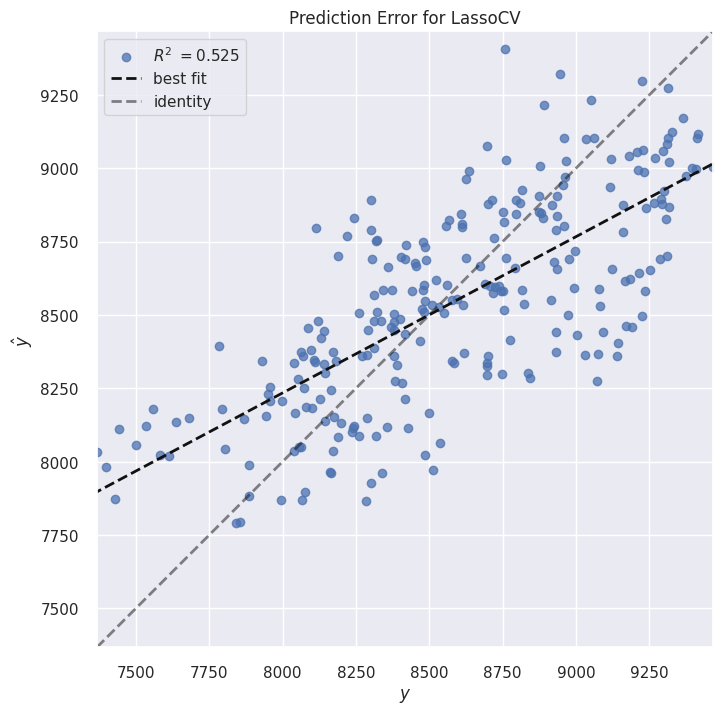

In [46]:
plt.figure(figsize=(8, 8))
visualizer = prediction_error(lasso_cv, X_test_2, y_test, is_fitted=True)

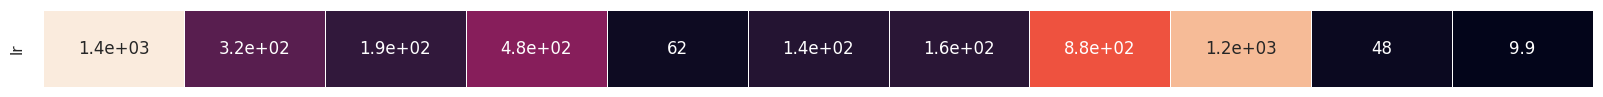

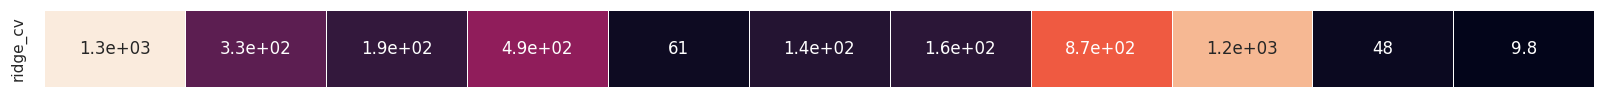

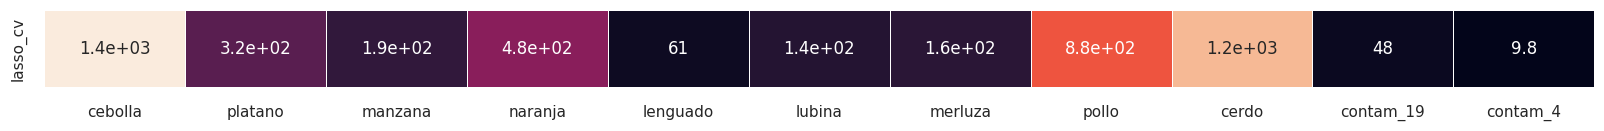

In [47]:
weights = pd.DataFrame({'lr':lr.coef_, 'ridge_cv':ridge_cv.coef_, 'lasso_cv':lasso_cv.coef_},index=X_train_2.columns)

fig,  ax = plt.subplots( figsize = (20,1));
sns.heatmap(weights.T.loc[['lr'],:].abs(),annot=True, linewidths=.5,ax=ax,cbar=False,xticklabels=False);

plt.figure(figsize = (20,1));
sns.heatmap(weights.T.loc[['ridge_cv'],:].abs(),annot=True, linewidths=.5,cbar=False,xticklabels=False);

plt.figure(figsize = (20,1));
sns.heatmap(weights.T.loc[['lasso_cv'],:].abs(),annot=True, linewidths=.5,cbar=False,xticklabels=True);

## Apartado f

A veces las interacciones entre las variables son importantes para obtener un mejor modelo.
Partid del conjunto de datos del que habéis quitado las variables no significativas y usad
la función PolynomialFeatures de scikit-learn para añadir características al conjunto de
datos que correspondan a polinomios de grado 2 para esas variables. Ajustad de nuevo una
regresión lineal y un modelo Ridge para estas variables y evaluad la calidad de los modelos.
Representad las predicciones respecto a los valores reales y comentad lo que observáis.

In [48]:
variables_no_significativas = [
    'temp_raval',
    'temp_fabra',
    'temp_uni',
    'patata',
    'dorada',
    'turismos',
    'vehiculos'
]

# Eliminamos las variables no significativas
X_significant = X.drop(columns=variables_no_significativas)

# Dividimos el conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X_significant, y, test_size=0.4, random_state=42)

from sklearn.preprocessing import PolynomialFeatures

# Creamos las características polinómicas de grado 2
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Ajustamos una regresión Ridge con validación cruzada y usando los nuevos datos
ridge_model = RidgeCV(alphas=[1e-4, 1e-3, 1e-2, 0.1, 0.5, 1, 5, 10, 50, 100], cv=5)
ridge_model.fit(X_train_poly, y_train)


RidgeCV(alphas=[0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100], cv=5)

<Figure size 800x800 with 0 Axes>

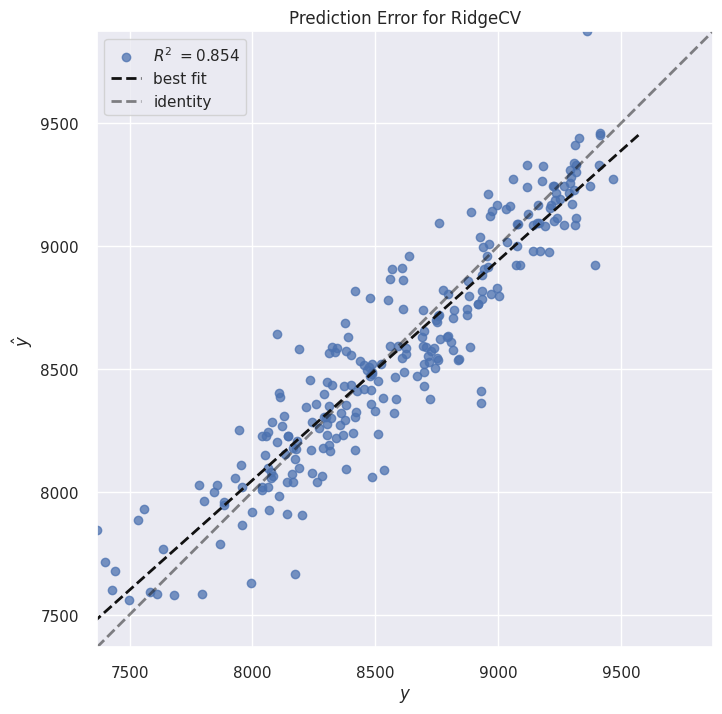

In [49]:
plt.figure(figsize=(8, 8))
visualizer = prediction_error(ridge_model, X_test_poly, y_test, is_fitted=True)

Se observa claramente como obtenemos un modelo mucho mejor. El usar PolynomialFeatures facilita la creación de nuevas características que permiten al modelo capturar relaciones no lineales, mejorando el rendimiento del modelo en comparación con un simple ajuste lineal de las características originales. Ajustar una regresión lineal a un conjunto de datos extendidos con todas las combinaciones polinomicas es exactamente lo mismo que tratar de ajustar una regresión polinomica a los datos originales.